In [16]:
import torch

# Check if the MPS (Apple's GPU) backend is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [18]:
from datasets import load_dataset, DatasetDict

# Loading dataset from CSV file
train_data = load_dataset('csv', data_files='3_split_data/train.csv')
test_data = load_dataset('csv', data_files='3_split_data/test.csv')
dataset = DatasetDict({
    'train': train_data['train'],
    'test': test_data['train'],
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 2792
    })
    test: Dataset({
        features: ['content', 'label'],
        num_rows: 698
    })
})


In [22]:
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Load tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['content'], padding='max_length', truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
print(tokenized_dataset)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2792
    })
    test: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 698
    })
})


In [24]:
from transformers import AutoModelForSequenceClassification

# Load XLM-RoBERTa model for sequence classification with 16 labels
model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=16)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.254800,1.145466,0.657593,0.579181,0.657593,0.592141
2,0.819500,0.792015,0.752149,0.694512,0.752149,0.711176
3,0.555300,0.711847,0.772206,0.756663,0.772206,0.741621


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


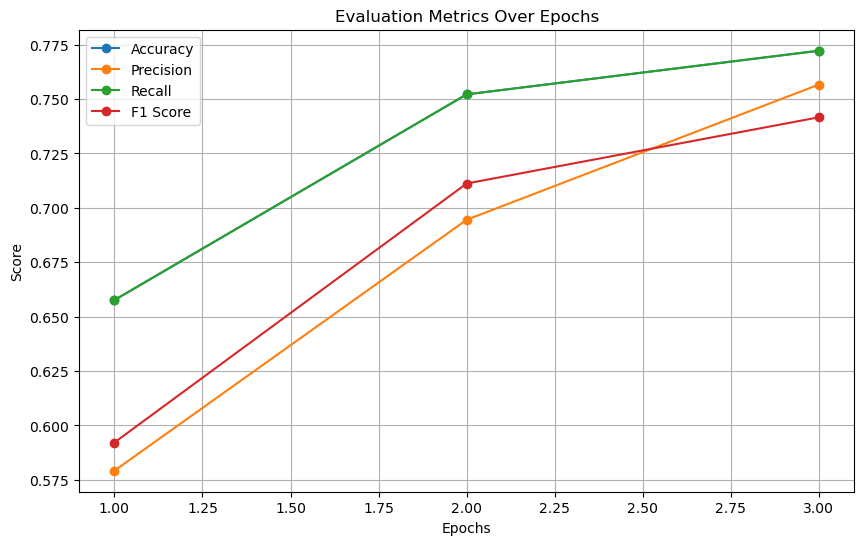

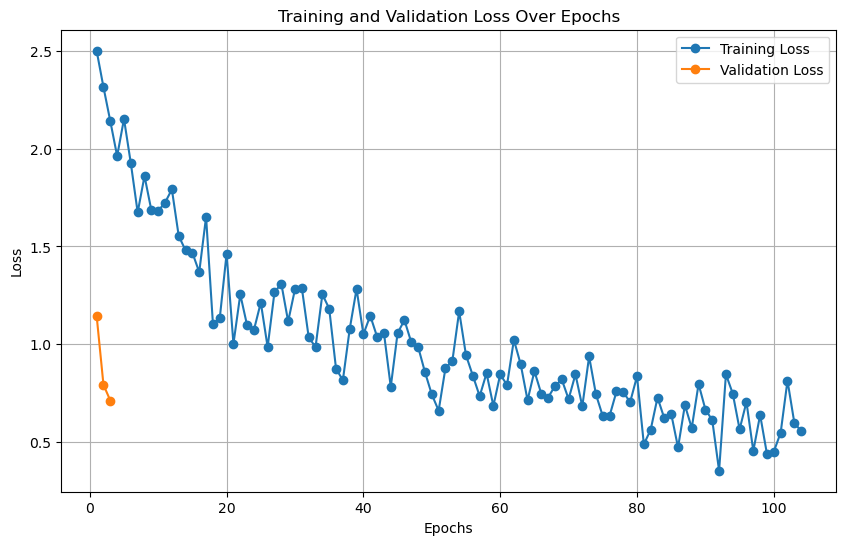

In [28]:
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Define compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    bf16=True  # Use FP16 precision for faster training on supported hardware
)

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics
)

# Fine-tune and evaluate the model
trainer.train()

# Retrieve training history
training_history = trainer.state.log_history

# Extract evaluation metrics and losses after each epoch
epochs = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
training_losses = []
eval_losses = []

for log in training_history:
    if 'eval_accuracy' in log:  # Log evaluation metrics
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'])
        precisions.append(log['eval_precision'])
        recalls.append(log['eval_recall'])
        f1_scores.append(log['eval_f1'])
    if 'loss' in log:  # Log training loss
        training_losses.append(log['loss'])
    if 'eval_loss' in log:  # Log evaluation loss
        eval_losses.append(log['eval_loss'])

# Plotting the evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.plot(epochs, precisions, label='Precision', marker='o')
plt.plot(epochs, recalls, label='Recall', marker='o')
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')
plt.title('Evaluation Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()